# Manufacturing Process Parameter Optimization Using CMA-ES

In this notebook, we'll explore how to use the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) to optimize manufacturing process parameters. This is a common industrial engineering problem where we need to balance multiple competing objectives.

CMA-ES is a powerful evolutionary algorithm for continuous parameter optimization, especially useful when:
- The objective function is non-linear or non-convex
- There are multiple local optima
- The function is noisy or complex

## Problem Description

We'll simulate a manufacturing process with three key parameters:
1. **Temperature** (°C): Acceptable range 150-250°C
2. **Pressure** (MPa): Acceptable range 5-15 MPa
3. **Processing time** (min): Acceptable range 10-30 minutes

We need to optimize these parameters to achieve multiple objectives:
- **Maximize production rate** (units/hour)
- **Minimize defect rate** (%)
- **Minimize energy consumption** (kWh)

Let's start by importing the necessary libraries and defining our objective functions.

In [3]:
import numpy as np
import cma
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Defining the Objective Functions

We'll define three objective functions, one for each goal we're trying to optimize:

1. **Production Rate**: We want to maximize this, so we'll negate the function since CMA-ES minimizes by default
2. **Defect Rate**: We want to minimize this (lower is better)
3. **Energy Consumption**: We want to minimize this (lower is better)

Each function will include penalties for solutions outside the acceptable parameter ranges.

In [4]:
# Manufacturing process parameter optimization example
# Objectives:
# 1. Maximize production rate (units/hour)
# 2. Minimize defect rate (%)
# 3. Minimize energy consumption (kWh)

def manufacturing_process(x):
    """
    Simulates a manufacturing process with the following parameters:
    x[0] = Temperature (°C), acceptable range: [150, 250]
    x[1] = Pressure (MPa), acceptable range: [5, 15]
    x[2] = Processing time (min), acceptable range: [10, 30]
    
    Returns the negative of production rate (we'll minimize, so negative means maximize production)
    """
    temperature, pressure, process_time = x
    
    # Penalize solutions outside acceptable ranges
    penalty = 0
    if temperature < 150 or temperature > 250:
        penalty += 1e9
    if pressure < 5 or pressure > 15:
        penalty += 1e9
    if process_time < 10 or process_time > 30:
        penalty += 1e9
    
    # Production rate model (units/hour)
    # Higher temperature and pressure increase production rate
    # Longer processing time decreases production rate
    production_rate = (
        20 + 0.1 * (temperature - 150) 
        + 2 * (pressure - 5) 
        - 0.8 * (process_time - 10)
    )
    
    # Add some interesting non-linearity
    production_rate += 5 * np.sin(temperature/25) * np.cos(pressure**2/9)
    
    # Add penalty
    return -np.maximum(0, production_rate) + penalty  # Negative because we're minimizing


In [5]:
def defect_rate(x):
    """
    Simulates defect rate for the manufacturing process.
    Returns defect percentage.
    """
    temperature, pressure, process_time = x
    
    # Penalize solutions outside acceptable ranges
    penalty = 0
    if temperature < 150 or temperature > 250:
        penalty += 1e9
    if pressure < 5 or pressure > 15:
        penalty += 1e9
    if process_time < 10 or process_time > 30:
        penalty += 1e9
    
    # Base defect rate
    defect = 5.0
    
    # Temperature affects defect rate with a sweet spot around 200°C
    defect += 0.05 * (temperature - 200)**2 / 25
    
    # Pressure affects defect rate with a sweet spot around 10 MPa
    defect += 0.5 * (pressure - 10)**2
    
    # Longer processing time generally reduces defects
    defect -= 0.1 * (process_time - 10)
    
    # Add some non-linearity
    defect += 2 * np.sin(temperature**3/(20**3)) * np.sin(pressure/2)
    
    return np.minimum(defect + penalty, 100)

In [6]:
def energy_consumption(x):
    """
    Simulates energy consumption for the manufacturing process.
    Returns energy consumption in kWh.
    """
    temperature, pressure, process_time = x
    
    # Penalize solutions outside acceptable ranges
    penalty = 0
    if temperature < 150 or temperature > 250:
        penalty += 1e9
    if pressure < 5 or pressure > 15:
        penalty += 1e9
    if process_time < 10 or process_time > 30:
        penalty += 1e9
    
    # Base energy consumption
    energy = 10.0
    
    # Higher temperature increases energy consumption
    energy += 0.2 * (temperature - 150)
    
    # Higher pressure increases energy consumption
    energy += 1.5 * (pressure - 5)
    
    # Longer processing time increases energy consumption
    energy += 0.5 * process_time
    
    return np.maximum(energy, 0) + penalty


## Multi-Objective Optimization

In industrial engineering, we often need to balance multiple competing objectives. There are several approaches to handle this:

1. **Weighted Sum**: Combine objectives with different weights based on their importance
2. **Pareto Front**: Find a set of non-dominated solutions
3. **Lexicographic**: Optimize objectives in order of priority

For simplicity, we'll use the weighted sum approach here, but you could extend this to find the Pareto front or use other multi-objective techniques.


In [7]:
def multi_objective(x, weights=[0.5, 0.3, 0.2]):
    """
    Combines multiple objectives using weighted sum approach.
    weights: [production_weight, defect_weight, energy_weight]
    """
    # Notice the negative on production rate is already applied in its function
    return (
        weights[0] * manufacturing_process(x) + 
        weights[1] * defect_rate(x) + 
        weights[2] * energy_consumption(x)
    )

## Single-Objective Optimization

Let's first optimize for just the production rate to see how CMA-ES works on a single objective.

CMA-ES requires:
- An initial solution (x0)
- An initial step size (sigma0)
- An objective function to minimize

The algorithm will then explore the solution space, adapting its search distribution based on successful solutions it finds.


In [8]:
# Run single-objective optimization for production rate
def optimize_production():
    print("Optimizing for production rate...")
    x0 = [200, 10, 20]  # Initial guess [temperature, pressure, process_time]
    sigma0 = 20  # Initial step size
    
    # Run CMA-ES optimization
    result = cma.fmin(manufacturing_process, x0, sigma0, 
                       options={'maxfevals': 1000, 'verb_disp': 1})
    
    # Extract the best solution
    best_params = result[0]
    best_production = -manufacturing_process(best_params)  # Convert back to positive
    best_defect = defect_rate(best_params)
    best_energy = energy_consumption(best_params)
    
    print(f"Best parameters: Temperature={best_params[0]:.2f}°C, "
          f"Pressure={best_params[1]:.2f}MPa, Process time={best_params[2]:.2f}min")
    print(f"Production rate: {best_production:.2f} units/hour")
    print(f"Defect rate: {best_defect:.2f}%")
    print(f"Energy consumption: {best_energy:.2f} kWh")
    
    return best_params, best_production, best_defect, best_energy

Now let's optimize all three objectives simultaneously using our weighted sum approach. 
By adjusting the weights, we can emphasize different objectives based on their importance to the manufacturing process.

In [9]:
def optimize_multi_objective(weights=[0.1, 0.1, 0.8]):
    print(f"Multi-objective optimization with weights: {weights}")
    x0 = [200, 10, 20]  # Initial guess [temperature, pressure, process_time]
    sigma0 = 20  # Initial step size
    
    # Create an objective function with fixed weights
    def objective(x):
        return multi_objective(x, weights)
    
    # Run CMA-ES optimization
    result = cma.fmin(objective, x0, sigma0, 
                       options={'maxfevals': 1000, 'verb_disp': 1})
    
    # Extract the best solution
    best_params = result[0]
    best_production = -manufacturing_process(best_params)  # Convert back to positive
    best_defect = defect_rate(best_params)
    best_energy = energy_consumption(best_params)
    
    print(f"Best parameters: Temperature={best_params[0]:.2f}°C, "
          f"Pressure={best_params[1]:.2f}MPa, Process time={best_params[2]:.2f}min")
    print(f"Production rate: {best_production:.2f} units/hour")
    print(f"Defect rate: {best_defect:.2f}%")
    print(f"Energy consumption: {best_energy:.2f} kWh")
    
    return best_params, best_production, best_defect, best_energy


## Visualizing the Objective Functions

To better understand our optimization problem, let's visualize each objective function.
We'll create 3D surface plots showing how the objectives change with temperature and pressure
(keeping process time fixed at 20 minutes for visualization purposes).

This visualization helps us understand:
- The shape and complexity of each objective function
- Potential local optima and challenges for optimization
- The conflicting nature of our multiple objectives

In [10]:
# Visualize the production rate objective function
def visualize_objective(objective_func, title):
    # Create a grid of temperature and pressure values (fixing process_time at 20)
    temp_range = np.linspace(150, 250, 50)
    pressure_range = np.linspace(5, 15, 50)
    T, P = np.meshgrid(temp_range, pressure_range)
    Z = np.zeros_like(T)
    
    # Calculate objective function value at each grid point
    for i in range(len(pressure_range)):
        for j in range(len(temp_range)):
            if objective_func == manufacturing_process:
                Z[i, j] = -objective_func([T[i, j], P[i, j], 20])  # Negate to show production
            else:
                Z[i, j] = objective_func([T[i, j], P[i, j], 20])
    
    # Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(T, P, Z, cmap=cm.viridis, alpha=0.8)
    
    # Add labels and colorbar
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Pressure (MPa)')
    if objective_func == manufacturing_process:
        ax.set_zlabel('Production Rate')
        ax.set_title(f'{title} (Process Time = 20min)')
    elif objective_func == defect_rate:
        ax.set_zlabel('Defect Rate (%)')
        ax.set_title(f'{title} (Process Time = 20min)')
    elif objective_func == defect_rate:
        ax.set_zlabel('Energy Consumption (kWh)')
        ax.set_title(f'{title} (Process Time = 20min)')
    else:
        ax.set_zlabel('Objective')
        ax.set_title(title)
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()

## Running the Optimization and Comparing Results

Now let's run both our single-objective and multi-objective optimizations and compare the results.
This will help us understand the trade-offs involved in optimizing for multiple competing objectives.

For the multi-objective case, we'll use weights that prioritize:
- Production rate (40%)
- Defect rate (30%)
- Energy consumption (30%)

In [11]:
# Run single-objective optimization for production rate
best_params_prod, best_production, best_defect_prod, best_energy_prod = optimize_production()

Optimizing for production rate...
(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=989495, Wed Oct  8 16:26:16 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 9.999999517878655e+08 1.0e+00 2.01e+01  2e+01  2e+01 0:00.0
    2     14 9.999999633416710e+08 1.3e+00 1.61e+01  1e+01  2e+01 0:00.0
    3     21 -3.241711324735037e+01 1.2e+00 1.47e+01  1e+01  1e+01 0:00.0
    4     28 9.999999245678827e+08 1.4e+00 1.82e+01  1e+01  2e+01 0:00.0
    5     35 9.999999900937334e+08 1.7e+00 1.62e+01  1e+01  2e+01 0:00.0
    6     42 9.999999455131191e+08 1.7e+00 1.43e+01  1e+01  1e+01 0:00.0
    7     49 9.999999330895559e+08 1.6e+00 1.43e+01  1e+01  1e+01 0:00.0
    8     56 9.999999124812611e+08 1.4e+00 1.49e+01  1e+01  1e+01 0:00.1
    9     63 9.999999345840188e+08 1.6e+00 1.27e+01  9e+00  1e+01 0:00.1
   10     70 -3.096220151487890e+01 1.5e+00 1.50e+01  1e+01  2e+01 0:00.1
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]


Now let's run the multi-objective optimization with differently balanced weights:

In [12]:
# Run multi-objective optimization with custom weights
weights = [0.3, 0.6, 0.1]  # Production, Defect, Energy
best_params_multi, best_production_multi, best_defect_multi, best_energy_multi = optimize_multi_objective(weights)

Multi-objective optimization with weights: [0.3, 0.6, 0.1]
(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=1042594, Wed Oct  8 16:26:17 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 4.000000449961317e+08 1.0e+00 1.70e+01  1e+01  2e+01 0:00.0
    2     14 4.000000476119620e+08 1.4e+00 1.62e+01  1e+01  2e+01 0:00.0
    3     21 3.816376357480347e-01 1.5e+00 1.47e+01  1e+01  1e+01 0:00.0
    4     28 8.643584932821096e-01 1.6e+00 1.92e+01  1e+01  3e+01 0:00.0
    5     35 4.000000486560062e+08 2.6e+00 1.93e+01  1e+01  2e+01 0:00.0
    6     42 4.000000413372227e+08 2.4e+00 2.08e+01  1e+01  3e+01 0:00.0
    7     49 4.000000230259154e+08 2.6e+00 2.67e+01  1e+01  4e+01 0:00.0
    8     56 4.000000192353035e+08 3.4e+00 2.92e+01  1e+01  5e+01 0:00.0
    9     63 3.999999801889989e+08 3.8e+00 3.95e+01  2e+01  7e+01 0:00.1
   10     70 3.999999522642705e+08 5.2e+00 5.51e+01  2e+01  1e+02 0:00.1
Iterat #Fevals   function value  axis ratio  sig

Let's compare the results from our two optimization approaches:

In [13]:
print("Comparison:")
print(f"Production optimization: {best_production:.2f} units/hour, {best_defect_prod:.2f}% defects, {best_energy_prod:.2f} kWh")
print(f"Multi-objective optimization: {best_production_multi:.2f} units/hour, {best_defect_multi:.2f}% defects, {best_energy_multi:.2f} kWh")

Comparison:
Production optimization: 32.42 units/hour, 7.51% defects, 34.74 kWh
Multi-objective optimization: 22.17 units/hour, 4.66% defects, 42.36 kWh


<div class="alert alert-block alert-success">
<h2>Exercise: Visualizing Each Objective Function</h2>

Visualize each objective function to better understand the optimization landscape. Then, visualize the multi-objective landscape with a fixed value of weights. When you change the weights, how does the optimization landscape change?
</div>

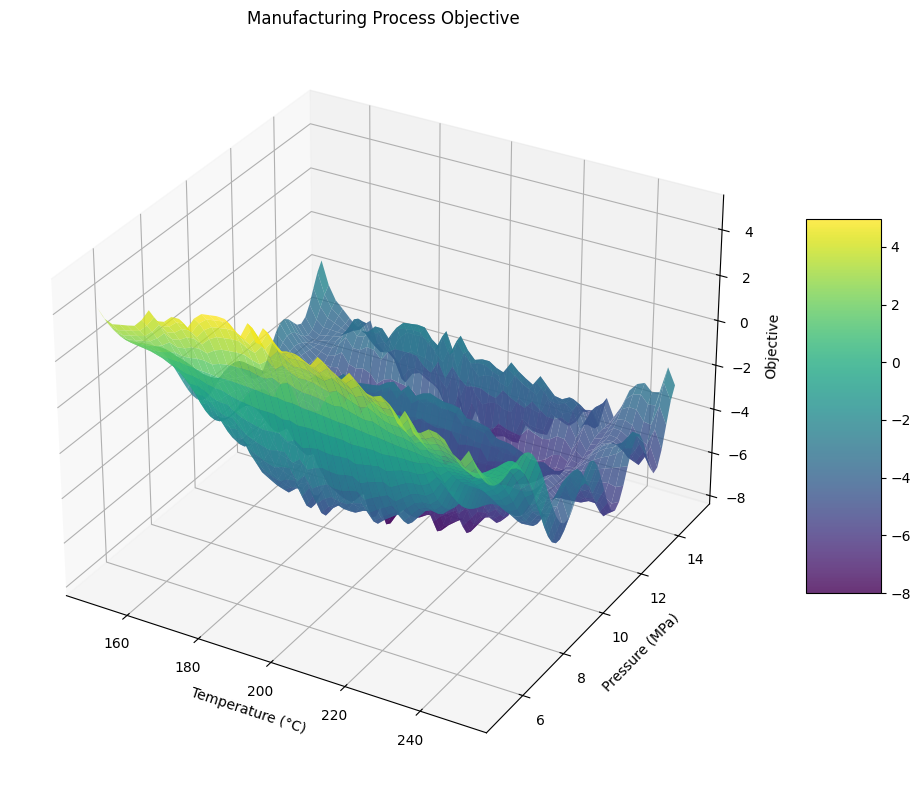

In [14]:
visualize_objective(multi_objective, "Manufacturing Process Objective")

## Exploring Different Weight Combinations

In industrial engineering, the importance of different objectives may vary based on business priorities.
Let's explore how different weight combinations affect our optimal solution.

In [15]:
def explore_weight_combinations(weight_combinations):
    # Define different weight combinations to explore
   
    results = []
    
    for weights in weight_combinations:
        print(f"\nOptimizing with weights: {weights}")
        best_params, production, defect, energy = optimize_multi_objective(weights)
        results.append((weights, best_params, production, defect, energy))
    
    # Display summary table
    print("\nWeight Combination Results Summary:")
    print("="*80)
    print("{:<30} {:<15} {:<15} {:<15}".format(
        "Weights [Prod, Defect, Energy]", "Production", "Defect Rate", "Energy"))
    print("-"*80)
    
    for weights, _, prod, defect, energy in results:
        weight_str = f"[{weights[0]:.1f}, {weights[1]:.1f}, {weights[2]:.1f}]"
        print("{:<30} {:<15.2f} {:<15.2f} {:<15.2f}".format(
            weight_str, prod, defect, energy))
    return results

In [16]:
def plot_weight_results(results):
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Normalize each metric for better visualization
    max_prod = max(result[2] for result in results)
    max_defect = max(result[3] for result in results)
    max_energy = max(result[4] for result in results)
    
    # Create x positions for the bars
    x = np.arange(len(results))
    width = 0.25  # width of the bars
    
    # Plot bars for each metric
    rects1 = ax.bar(x - width, [result[2]/max_prod for result in results], width, label='Production Rate')
    rects2 = ax.bar(x, [1 - result[3]/max_defect for result in results], width, label='Quality (1-Defect)')
    rects3 = ax.bar(x + width, [1 - result[4]/max_energy for result in results], width, label='Energy Efficiency')
    
    # Add labels and legend
    ax.set_ylabel('Normalized Performance')
    ax.set_title('Optimization Results with Different Weight Combinations')
    ax.set_xticks(x)
    ax.set_xticklabels([f"W{i+1}" for i in range(len(results))])
    ax.legend()
    
    # Add a text box explaining the weight combinations
    textstr = '\n'.join([
        f"W1: Production-focused {results[0][0]}",
        f"W2: Quality-focused {results[1][0]}",
        f"W3: Energy-focused {results[2][0]}",
        f"W4: Balanced {results[3][0]}"
    ])
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=props)
    
    plt.tight_layout()
    plt.show()

<div class="alert alert-block alert-success">
<h2>Exercise: Different weight combinations</h2>

Compare different weight combinations. Each weight combination should sum to 1. Try configurations that heavily prioritizes production, quality, and energy efficiency, as well as one that is equal. Using the above functions, solve these combinations using CMA-ES and plot the results.</div>

In [17]:
weight_combinations = [
    [0.8, 0.1, 0.1],  # Heavily prioritize production
    [0.1, 0.8, 0.1],  # Heavily prioritize production
    [0.1, 0.1, 0.8],  # Heavily prioritize production
    [0.34, 0.33, 0.33]
]

In [23]:
results = explore_weight_combinations(weight_combinations)


Optimizing with weights: [0.8, 0.1, 0.1]
Multi-objective optimization with weights: [0.8, 0.1, 0.1]
(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=1103966, Wed Oct  8 16:49:36 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 8.999999687696910e+08 1.0e+00 2.16e+01  2e+01  3e+01 0:00.0
    2     14 -1.855754002975358e+01 1.4e+00 1.86e+01  1e+01  2e+01 0:00.0
    3     21 -1.028995553215346e+01 1.6e+00 1.80e+01  1e+01  2e+01 0:00.0
    4     28 -9.200440254653282e+00 1.8e+00 1.97e+01  1e+01  2e+01 0:00.0
    5     35 -8.756781278385168e+00 1.8e+00 1.54e+01  9e+00  2e+01 0:00.0
    6     42 8.999999713761609e+08 2.0e+00 1.48e+01  1e+01  1e+01 0:00.0
    7     49 -1.818286161292565e+01 1.8e+00 1.30e+01  8e+00  1e+01 0:00.0
    8     56 -1.501197852161938e+01 1.6e+00 1.21e+01  8e+00  1e+01 0:00.0
    9     63 -3.817661348762804e+00 1.6e+00 1.33e+01  9e+00  1e+01 0:00.0
   10     70 -1.210820684366310e+01 1.5e+00 1.15e+01  7e+00  8e+00 0:00.

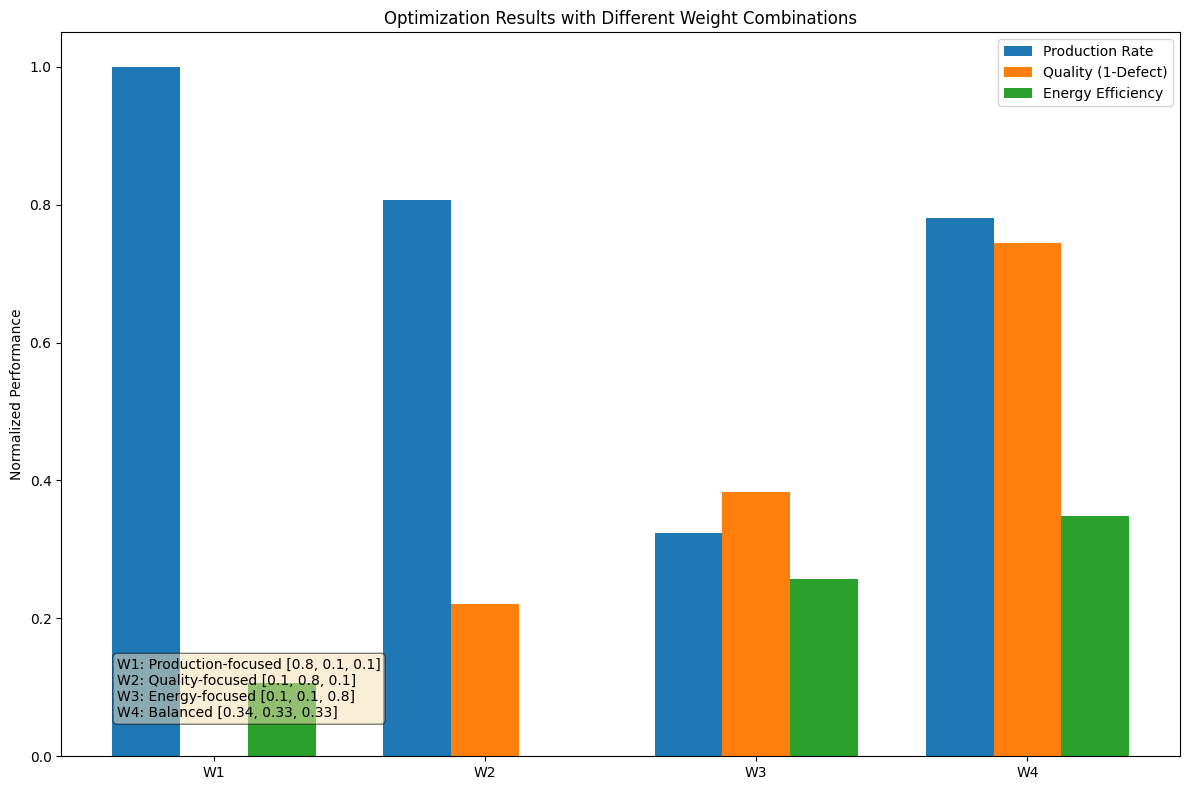

In [24]:
plot_weight_results(results)